#1- File Selection + Handling missing/outliers + Feature engineering:

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Function to display dataset information
def dataset_info(data):
    print("First few rows of the dataset:")
    print(data.head())
    print("\nDataset shape (rows, columns):", data.shape)
    print("\nColumn names and data types:")
    print(data.dtypes)
    print("\nSummary statistics for numeric columns:")
    print(data.describe())
    print("\nMissing values in each column:")
    print(data.isnull().sum())

# Function to handle missing values by dropping rows with any missing values
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print("Missing values in each column before cleaning:")
    print(missing_values[missing_values > 0])
    data_cleaned = data.dropna()
    print(f"\nData shape after removing rows with missing values: {data_cleaned.shape}")
    missing_values_after = data_cleaned.isnull().sum().sum()
    if missing_values_after == 0:
        print("\nNo missing values remain after cleaning.")
    else:
        print(f"\nWarning: {missing_values_after} missing values still remain.")
    return data_cleaned

# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, columns, threshold=1.5):
    data_no_outliers = data.copy()
    initial_shape = data_no_outliers.shape[0]  # Track initial rows
    for col in columns:
        if col in data_no_outliers.columns:
            # Calculate IQR
            Q1 = data_no_outliers[col].quantile(0.25)
            Q3 = data_no_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            # Define bounds
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            # Filter out outliers
            data_no_outliers = data_no_outliers[(data_no_outliers[col] >= lower_bound) &
                                                (data_no_outliers[col] <= upper_bound)]
    rows_removed = initial_shape - data_no_outliers.shape[0]
    print(f"Outliers removed: {rows_removed} rows")
    print(f"Data shape after outlier removal: {data_no_outliers.shape}")
    return data_no_outliers

from sklearn.preprocessing import StandardScaler, LabelEncoder

def feature_engineering(data, numeric_cols, nominal_cols_one_hot=['proto', 'state', 'service'], binary_col='attack_cat'):
    """
    Perform feature engineering by encoding categorical features, scaling numeric features,
    and optionally extracting time-based features from timestamp columns.

    Parameters:
    data (DataFrame): The cleaned dataset to process
    numeric_cols (list): List of numeric columns to scale
    nominal_cols_one_hot (list): List of nominal columns to one-hot encode
    binary_col (str): Binary or multi-class column to label encode (default is 'attack_cat')

    Returns:
    DataFrame: Dataset after feature engineering
    """
    data_fe = data.copy()

    # Step 1: Encoding categorical features

    # One-hot encode multi-category nominal features
    data_fe = pd.get_dummies(data_fe, columns=[col for col in nominal_cols_one_hot if col in data_fe.columns])

    # Label encode binary categorical column (e.g., attack_cat)
    if binary_col in data_fe.columns:
        le = LabelEncoder()
        data_fe[binary_col] = le.fit_transform(data_fe[binary_col])

    # Step 2: Scale numeric features
    # Ensure all numeric_cols are present in the DataFrame
    numeric_cols_present = [col for col in numeric_cols if col in data_fe.columns]

    # If any columns are missing, print a warning and proceed with available columns
    missing_cols = set(numeric_cols) - set(numeric_cols_present)
    if missing_cols:
        print(f"Warning: The following numeric columns are not in the DataFrame and were skipped during scaling: {missing_cols}")

    #If there are columns to scale
    if numeric_cols_present:
      scaler = StandardScaler()
      data_fe[numeric_cols_present] = scaler.fit_transform(data_fe[numeric_cols_present])

    # Step 3: Feature extraction from timestamps (optional)
    if 'Stime' in data_fe.columns:
        data_fe['Stime_hour'] = pd.to_datetime(data_fe['Stime'], unit='s').dt.hour
        data_fe['Stime_day'] = pd.to_datetime(data_fe['Stime'], unit='s').dt.day
        data_fe.drop(columns=['Stime'], inplace=True)

    if 'Ltime' in data_fe.columns:
        data_fe['Ltime_hour'] = pd.to_datetime(data_fe['Ltime'], unit='s').dt.hour
        data_fe['Ltime_day'] = pd.to_datetime(data_fe['Ltime'], unit='s').dt.day
        data_fe.drop(columns=['Ltime'], inplace=True)

    # Display final DataFrame shape and columns
    print("Final DataFrame shape:", data_fe.shape)
    print("DataFrame columns after feature engineering:", data_fe.columns)

        # Get the original attack category names
    attack_cat_names = list(le.classes_)

    # Print the mapping of labels to names
    for i, name in enumerate(attack_cat_names):
        print(f"Class {i}: {name}")

    return data_fe

# Define the column types based on provided information
nominal_cols = ['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat']
integer_cols = [
    'sport', 'dsport', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Spkts',
    'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
    'res_bdy_len', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src',
    'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
    'ct_dst_src_ltm'
]
float_cols = [
    'dur', 'Sload', 'Dload', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat'
]
binary_cols = ['is_sm_ips_ports', 'is_ftp_login', 'label']
numeric_cols = integer_cols + float_cols

# Load the pre-split data
train_path = '/content/UNSW_NB15_training-set.csv'
test_path = '/content/UNSW_NB15_testing-set.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Apply functions to the training set
print("Training Set Information:")
dataset_info(train_data)
train_data_cleaned = handle_missing_values(train_data)
train_data_no_outliers = remove_outliers_iqr(train_data_cleaned, numeric_cols, threshold=1.5)
train_data_fe = feature_engineering(train_data_no_outliers, numeric_cols)

# Apply functions to the testing set
print("\nTesting Set Information:")
dataset_info(test_data)
test_data_cleaned = handle_missing_values(test_data)
test_data_no_outliers = remove_outliers_iqr(test_data_cleaned, numeric_cols, threshold=1.5)
test_data_fe = feature_engineering(test_data_no_outliers, numeric_cols)

# Display final shapes of the processed training and testing sets
print("\nFinal shape of processed training set:", train_data_fe.shape)
print("Final shape of processed testing set:", test_data_fe.shape)


Training Set Information:
First few rows of the dataset:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_d

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and display metrics for multi-class classification
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
# Remove columns containing 'id' or 'label' from feature sets
drop_columns = [col for col in train_data_fe.columns if 'id' in col.lower() or 'label' in col.lower()]

# Separate features and target for training and testing sets
X_train = train_data_fe.drop(columns=['attack_cat'] + drop_columns)
y_train = train_data_fe['attack_cat']
X_test = test_data_fe.drop(columns=['attack_cat'] + drop_columns)
y_test = test_data_fe['attack_cat']

Random Forest Model Evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6414
Precision (Macro): 0.3895
Recall (Macro): 0.3042
F1 Score (Macro): 0.2785


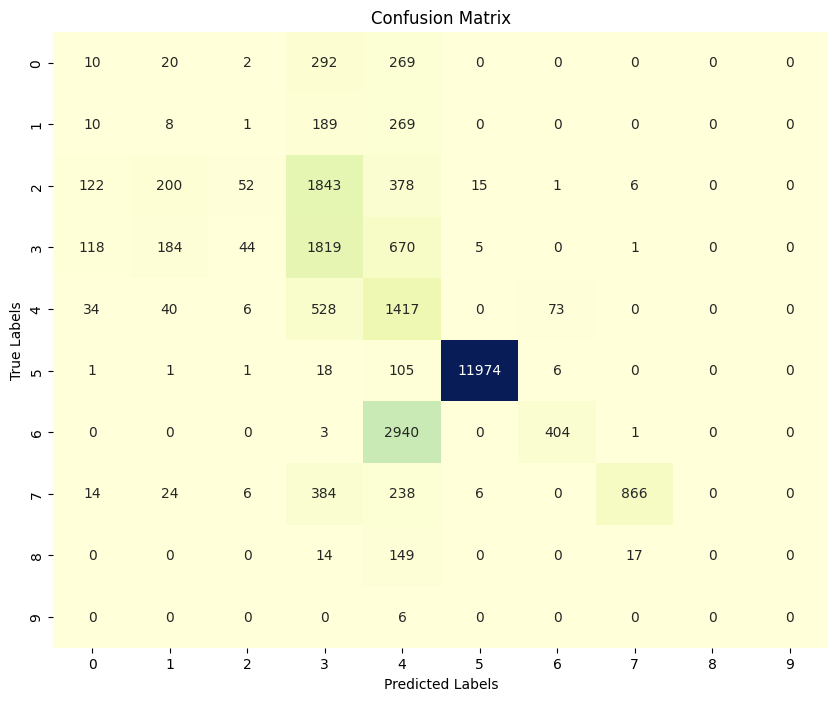

In [ ]:
# Step 1: Random Forest Model
print("Random Forest Model Evaluation:")
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_model(y_test, y_pred_rf)


XGBoost Model Evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5636
Precision (Macro): 0.2941
Recall (Macro): 0.2373
F1 Score (Macro): 0.1990


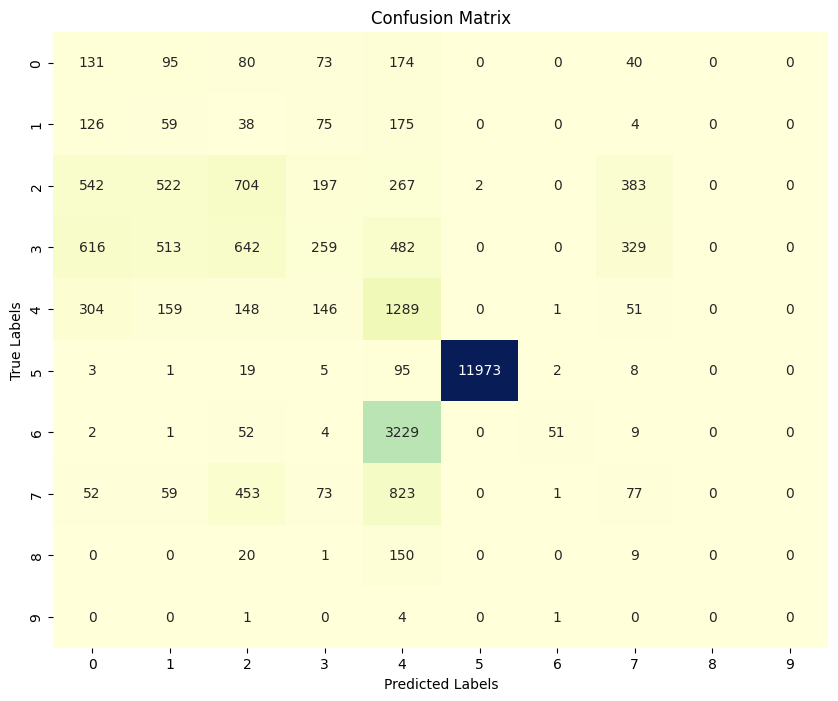

In [ ]:
# Step 2: XGBoost Model
print("\nXGBoost Model Evaluation:")
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(y_train.unique()), eval_metric='mlogloss', random_state=42)
# Remove early_stopping_rounds
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_xgb)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib  # For saving the model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grids for the models
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize GridSearchCV for Random Forest model
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Run grid search on Random Forest model
print("Starting Grid Search for Random Forest...")
rf_grid_search.fit(X_train, y_train)

# Extract the best parameters and results
best_rf_params = rf_grid_search.best_params_
print(f"Best Random Forest Parameters: {best_rf_params}")

# Save the best model
best_rf_model = rf_grid_search.best_estimator_
joblib.dump(best_rf_model, 'best_rf_model.joblib')
print("Best Random Forest model saved as 'best_rf_model.joblib'.")

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics for the Best Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Starting Grid Search for Random Forest...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Random Forest model saved as 'best_rf_model.joblib'.
Evaluation Metrics for the Best Model:
Accuracy: 0.6539
Precision: 0.7642
Recall: 0.6539
F1 Score: 0.6106


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
from xgboost import XGBClassifier

# Define the parameter grids for the models
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(y_train.unique()), eval_metric='mlogloss', random_state=42)

# Initialize GridSearchCV for the XGBoost model
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Run grid search on XGBoost model
print("Starting Grid Search for XGBoost...")
xgb_grid_search.fit(X_train, y_train)

# Extract the best parameters and results
best_xgb_params = xgb_grid_search.best_params_
print(f"Best XGBoost Parameters: {best_xgb_params}")

# Save the best model
best_xgb_model = xgb_grid_search.best_estimator_
joblib.dump(best_xgb_model, 'best_xgb_model.joblib')
print("Best XGBoost model saved as 'best_xgb_model.joblib'.")

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics for the Best XGBoost Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Starting Grid Search for XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost model saved as 'best_xgb_model.joblib'.
Evaluation Metrics for the Best XGBoost Model:
Accuracy: 0.5406
Precision: 0.6022
Recall: 0.5406
F1 Score: 0.5127


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
